## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd

import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing libraries for text processing steps.

!pip install textblob
!pip install wordcloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Opening JSON file 
f = open("complaints-2021-05-14_08_16.json") # Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

# row/column display limit
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [5]:
df.shape

(78313, 22)

In [6]:
#print the column names
col_names_list=list(df.columns)
col_names_list

['_index',
 '_type',
 '_id',
 '_score',
 '_source.tags',
 '_source.zip_code',
 '_source.complaint_id',
 '_source.issue',
 '_source.date_received',
 '_source.state',
 '_source.consumer_disputed',
 '_source.product',
 '_source.company_response',
 '_source.company',
 '_source.submitted_via',
 '_source.date_sent_to_company',
 '_source.company_public_response',
 '_source.sub_product',
 '_source.timely',
 '_source.complaint_what_happened',
 '_source.sub_issue',
 '_source.consumer_consent_provided']

In [7]:
#Assign new column names
df.columns=[re.sub('^_source.','',col) for col in df.columns]

In [8]:
df.columns=[re.sub('^_','',col) for col in df.columns]

In [9]:
col_names_list=list(df.columns)
col_names_list

['index',
 'type',
 'id',
 'score',
 'tags',
 'zip_code',
 'complaint_id',
 'issue',
 'date_received',
 'state',
 'consumer_disputed',
 'product',
 'company_response',
 'company',
 'submitted_via',
 'date_sent_to_company',
 'company_public_response',
 'sub_product',
 'timely',
 'complaint_what_happened',
 'sub_issue',
 'consumer_consent_provided']

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      78313 non-null  object 
 1   type                       78313 non-null  object 
 2   id                         78313 non-null  object 
 3   score                      78313 non-null  float64
 4   tags                       10900 non-null  object 
 5   zip_code                   71556 non-null  object 
 6   complaint_id               78313 non-null  object 
 7   issue                      78313 non-null  object 
 8   date_received              78313 non-null  object 
 9   state                      76322 non-null  object 
 10  consumer_disputed          78313 non-null  object 
 11  product                    78313 non-null  object 
 12  company_response           78313 non-null  object 
 13  company                    78313 non-null  obj

In [11]:
df.describe()

,score
count,78313.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [12]:
round(df.isna().sum()*100/78313,2)

index                         0.00
type                          0.00
id                            0.00
score                         0.00
tags                         86.08
zip_code                      8.63
complaint_id                  0.00
issue                         0.00
date_received                 0.00
state                         2.54
consumer_disputed             0.00
product                       0.00
company_response              0.00
company                       0.00
submitted_via                 0.00
date_sent_to_company          0.00
company_public_response      99.99
sub_product                  13.50
timely                        0.00
complaint_what_happened       0.00
sub_issue                    59.12
consumer_consent_provided     1.29
dtype: float64

In [13]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].replace("", np.nan, inplace=True)

In [14]:
round(df.isna().sum()*100/78313,2)

index                         0.00
type                          0.00
id                            0.00
score                         0.00
tags                         86.08
zip_code                      8.63
complaint_id                  0.00
issue                         0.00
date_received                 0.00
state                         2.54
consumer_disputed             0.00
product                       0.00
company_response              0.00
company                       0.00
submitted_via                 0.00
date_sent_to_company          0.00
company_public_response      99.99
sub_product                  13.50
timely                        0.00
complaint_what_happened      73.09
sub_issue                    59.12
consumer_consent_provided     1.29
dtype: float64

In [15]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'], inplace=True)

df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [16]:
# Write your function here to clean the text and remove all the unnecessary elements.
def text_preprocess(text):
    #Make the text lowercase
    text=text.lower()
    
    #Remove text in square brackets
    text=re.sub(r'\[.*?\]','',text)
    
    #Remove punctuation
    text=re.sub(r'[%s]%re.escape(string.punctuation)','',text)
    
    #Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    return text

df['complaint_what_happened']= df['complaint_what_happened'].apply(lambda x: text_preprocess(x))

In [17]:
#Write your function to Lemmatize the texts
def texts_lemma(text):     
        
    # Initialize empty list to store lemmas
    lemma_list = []
    
    # Extract lemmas of given text and add to the list 'sent'
    document = nlp(text)
    for word in document:
        lemma_list.append(word.lemma_)
        
    # return string converted form of the list of lemmas
    return " ".join(lemma_list)

df["lemmatized_complaint"] =  df.apply(lambda x: texts_lemma(x['complaint_what_happened']), axis=1)

In [18]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean=df[['complaint_what_happened','lemmatized_complaint']]

In [19]:
df_clean.head(5)

,complaint_what_happened,lemmatized_complaint
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember services . \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable . I be ask the bank to validate the debt . instead I been receive mail every month from they attempt to collect a debt . \n I have a right to know this information as a consumer . \n\n chase account # xxxx xxxx xxxx xxxx thank in advance for your help .
2,i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in xx / xx/ and be tell by the agent who do the upgrade my anniversary date would not change . it turn the agent be give I the wrong information in order to upgrade the account . xxxx change my anniversary date from xx / xx / xxxx to xx / xx / xxxx without my consent ! xxxx have the recording of the agent who be mislead I .
10,"chase card was reported on xx/xx/. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.","chase card be report on xx / xx/. however , fraudulent application have be submit my identity without my consent to fraudulently obtain service . do not extend credit without verify the identity of the applicant ."
11,"on xx/xx/, while trying to book a xxxx xxxx ticket, i came across an offer for {$.} to be applied towards the ticket if i applied for a rewards card. i put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. i immediately contacted xxxx and was referred to chase bank. i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why. i asked for more information about the xxxx offer and she explained that even if i had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account. i asked that the application be withdrawn and the representative obliged. this all happened no later than after putting in the application on xx/xx/. notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative, chase did in fact go ahead to open a credit account in my name on xx/xx/. this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error.","on xx / xx/ , while try to book a xxxx xxxx ticket , I come across an offer for { $ . } to be apply towards the ticket if I apply for a reward card . I put in my information for the offer and within less than a minute , be notify via the screen that a decision could not be make . I immediately contact xxxx and be refer to chase bank . I then immediately contact c

In [20]:
#Write your function to extract the POS tags 
def pos_tag(text):
    # Creating a textblob object
    text_blob = TextBlob(text)
    
    # extracting words with tags 'NN', joining them and return
    return ' '.join([ word for (word,tag) in text_blob.tags if tag == "NN"])


In [21]:
#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].

df_clean["complaint_POS_removed"] = df_clean.apply(lambda x: pos_tag(x['lemmatized_complaint']), axis=1) 

In [22]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head(5)

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember services . \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable . I be ask the bank to validate the debt . instead I been receive mail every month from they attempt to collect a debt . \n I have a right to know this information as a consumer . \n\n chase account # xxxx xxxx xxxx xxxx thank in advance for your help .,morning name stop bank cardmember ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help
2,i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in xx / xx/ and be tell by the agent who do the upgrade my anniversary date would not change . it turn the agent be give I the wrong information in order to upgrade the account . xxxx change my anniversary date from xx / xx / xxxx to xx / xx / xxxx without my consent ! xxxx have the recording of the agent who be mislead I .,card agent upgrade date agent information order account xxxx change date xxxx consent recording agent
10,"chase card was reported on xx/xx/. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.","chase card be report on xx / xx/. however , fraudulent application have be submit my identity without my consent to fraudulently obtain service . do not extend credit without verify the identity of the applicant .",card application identity consent service credit identity applicant
11,"on xx/xx/, while trying to book a xxxx xxxx ticket, i came across an offer for {$.} to be applied towards the ticket if i applied for a rewards card. i put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. i immediately contacted xxxx and was referred to chase bank. i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why. i asked for more information about the xxxx offer and she explained that even if i had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account. i asked that the application be withdrawn and the representative obliged. this all happened no later than after putting in the application on xx/xx/. notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative, chase did in fact go ahead to open a credit account in my name on xx/xx/. this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error.","on xx / xx/ , while t

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [23]:
df_clean.complaint_what_happened.str.len().sort_values(ascending=False)

1096     31480
31952    30898
48112    29834
6262     28913
3612     25291
26169    25094
28689    23601
18007    22663
11231    21672
25650    20927
14476    19978
74779    19475
71519    19419
76593    19410
72671    19362
43727    19113
316      18918
18058    17603
62341    17527
57396    17454
33207    16971
14154    16548
33413    16543
14281    15888
1614     15735
74874    15633
28112    15300
5423     14942
18455    14894
58239    14457
31013    14259
8414     14245
6490     14057
57680    13969
40604    13688
26806    13593
11425    13333
3788     13272
31944    13247
7782     13056
11771    12957
11683    12857
14058    12771
4485     12663
15326    12406
17051    12368
69448    11991
17487    11915
17332    11815
18054    11745
57389    11707
18102    11645
55949    11643
20794    11550
22494    11441
32303    11325
15984    11182
21774    11041
40766    10895
65075    10738
18543    10692
12394    10644
6399     10608
10835    10572
73918    10466
40014    10385
33976    1

Text(0, 0.5, 'No. of Complaints')

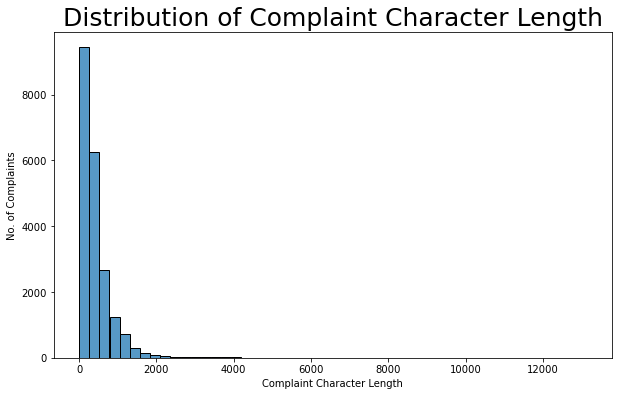

In [24]:
# Write your code here to visualise the data according to the 'Complaint' character length
char_len=[len(x) for x in df_clean['complaint_POS_removed']]
plt.figure(figsize=[10,6])
sns.histplot(data = char_len,bins=50)
plt.title('Distribution of Complaint Character Length', fontsize=25)
plt.xlabel('Complaint Character Length',size=10)
plt.ylabel('No. of Complaints',size=10)

#### Find the top 40 words by frequency among all the articles after processing the text.

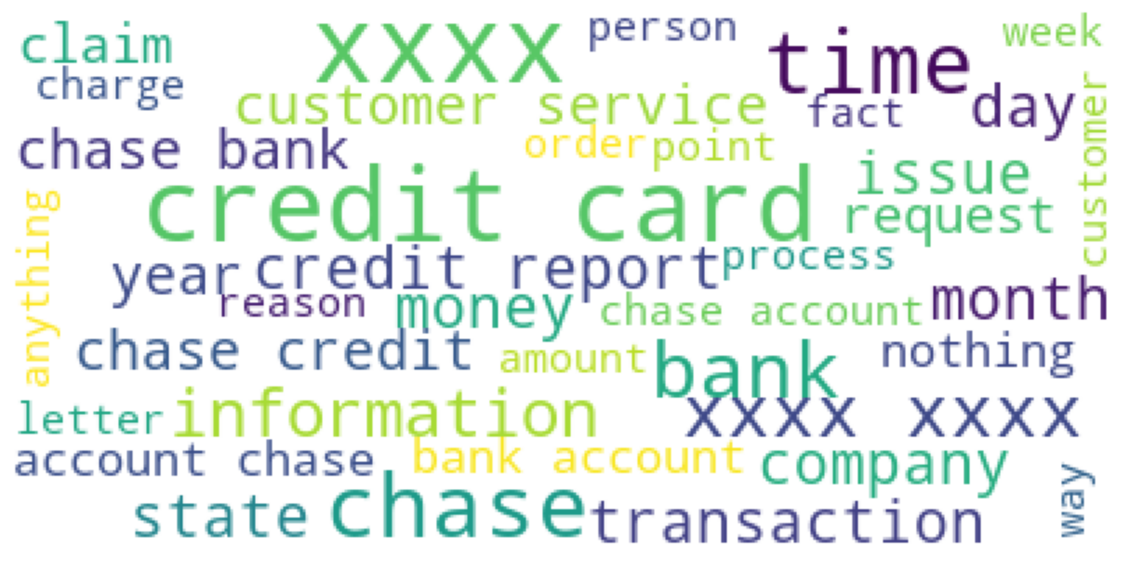

In [25]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
stop_words = set(STOPWORDS)
word_cloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_font_size=38,
                          max_words=38, 
                          random_state=42
                         ).generate(str(df_clean['complaint_POS_removed']))

fig = plt.figure(figsize=(20,16))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [26]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [27]:
# Importing required libraries.
from nltk.util import ngrams 
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer

In [28]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_unigram(text, n=30):
    vector = CountVectorizer(stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [29]:
#Print the top 10 words in the unigram frequency
top_common_words = get_top_unigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_unigram = pd.DataFrame(top_common_words, columns = ['unigram' , 'count'])
df_unigram.head(10)

,unigram,count
0,chase,49227
1,account,47897
2,xxxx,43331
3,credit,34283
4,card,29632
5,bank,28508
6,payment,21336
7,time,16289
8,charge,15151
9,day,13065


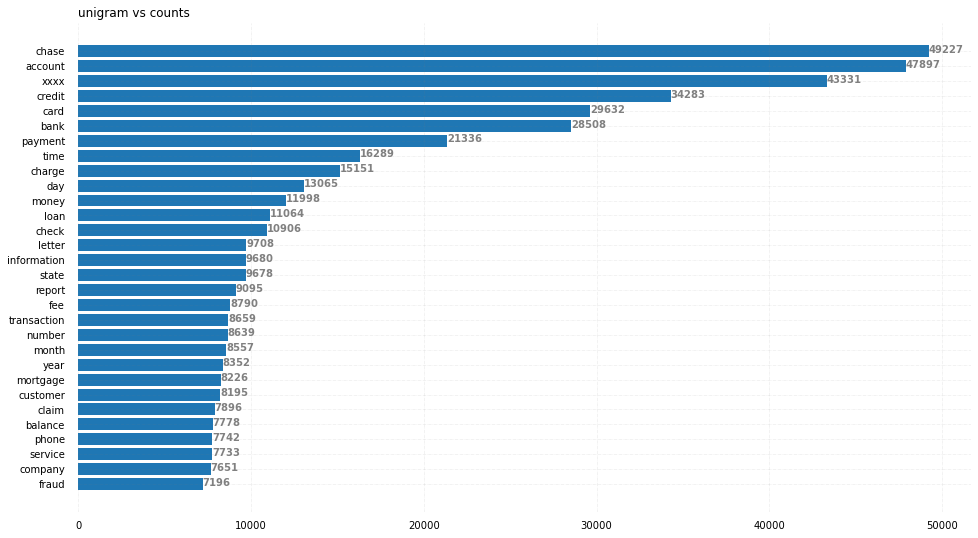

In [30]:
unigram = df_unigram['unigram'].head(30)
count = df_unigram['count'].head(30)

# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))

# Horizontal Bar Plot
ax.barh(unigram, count)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add x, y gridlines
ax.grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.5,alpha = 0.2)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

# Add Plot Title
ax.set_title('unigram vs counts',loc ='left', )
# Show Plot
plt.show()

In [31]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_bigram(text, n=30):
    vector = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [32]:
#Print the top 10 words in the bigram frequency
top_common_words = get_top_bigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_bigram = pd.DataFrame(top_common_words, columns = ['bigram' , 'count'])
df_bigram.head(10)

,bigram,count
0,credit card,12879
1,xxxx xxxx,6252
2,credit report,4002
3,customer service,3080
4,chase credit,3062
5,chase bank,2932
6,bank account,2807
7,chase account,2770
8,account chase,2762
9,account account,2338


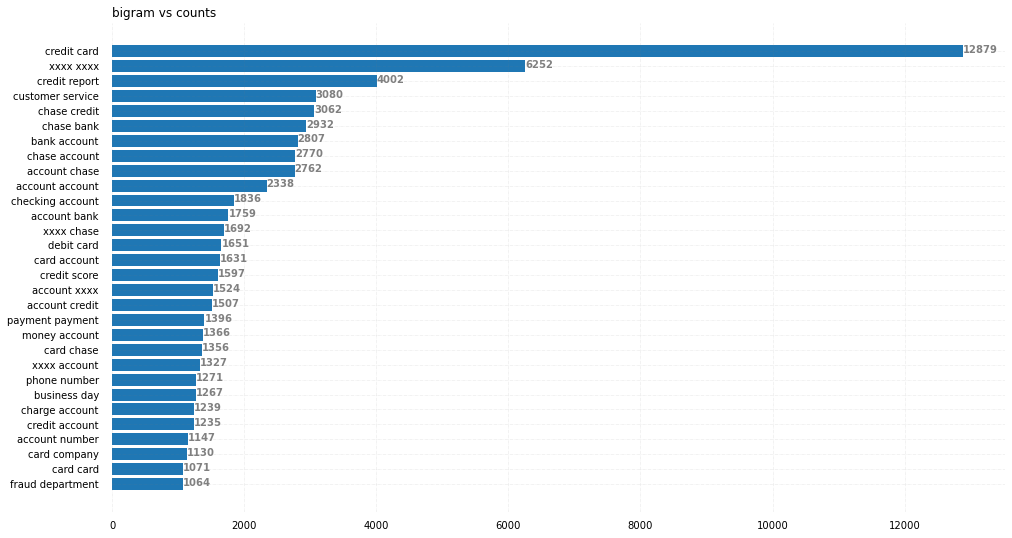

In [33]:
bigram = df_bigram['bigram'].head(30)
count = df_bigram['count'].head(30)

# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))

# Horizontal Bar Plot
ax.barh(bigram, count)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add x, y gridlines
ax.grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.5,alpha = 0.2)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

# Add Plot Title
ax.set_title('bigram vs counts',loc ='left', )
# Show Plot
plt.show()

In [34]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_trigram(text, n=30):
    vector = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [35]:
#Print the top 10 words in the trigram frequency
top_common_words = get_top_trigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_trigram = pd.DataFrame(top_common_words, columns = ['trigram' , 'count'])
df_trigram.head(10)

,trigram,count
0,chase credit card,2140
1,xxxx xxxx xxxx,1062
2,credit card account,1057
3,credit card company,994
4,credit card chase,673
5,credit card credit,508
6,inquiry credit report,482
7,charge credit card,431
8,account credit card,418
9,card credit card,381


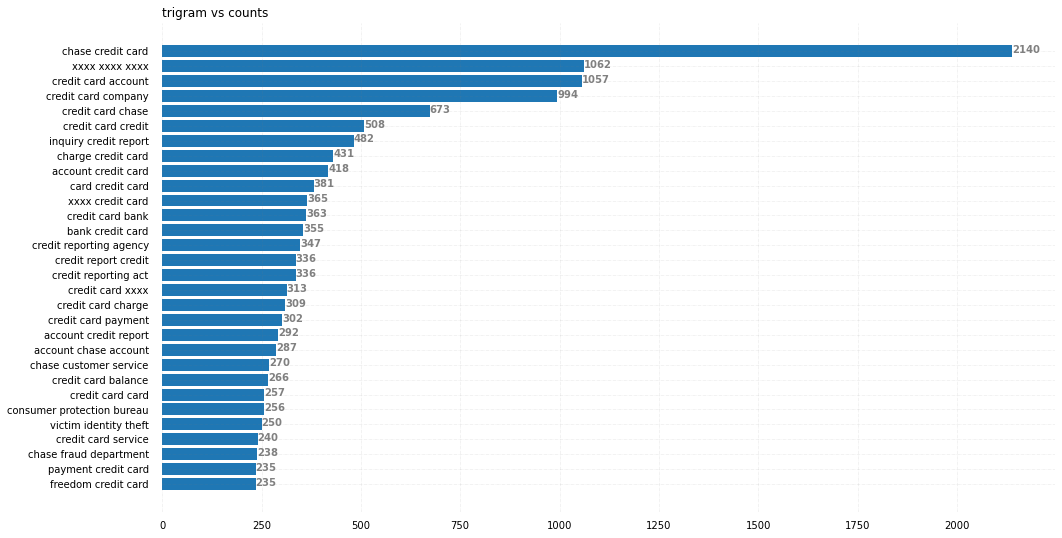

In [36]:
trigram = df_trigram['trigram'].head(30)
count = df_trigram['count'].head(30)

# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))

# Horizontal Bar Plot
ax.barh(trigram, count)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add x, y gridlines
ax.grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.5,alpha = 0.2)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

# Add Plot Title
ax.set_title('trigram vs counts',loc ='left', )
# Show Plot
plt.show()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [37]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [38]:
#All masked texts has been removed
df_clean.head(5)

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember services . \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable . I be ask the bank to validate the debt . instead I been receive mail every month from they attempt to collect a debt . \n I have a right to know this information as a consumer . \n\n chase account # xxxx xxxx xxxx xxxx thank in advance for your help .,morning name stop bank cardmember ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,morning name stop bank cardmember ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help
2,i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in xx / xx/ and be tell by the agent who do the upgrade my anniversary date would not change . it turn the agent be give I the wrong information in order to upgrade the account . xxxx change my anniversary date from xx / xx / xxxx to xx / xx / xxxx without my consent ! xxxx have the recording of the agent who be mislead I .,card agent upgrade date agent information order account xxxx change date xxxx consent recording agent,card agent upgrade date agent information order account change date consent recording agent
10,"chase card was reported on xx/xx/. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.","chase card be report on xx / xx/. however , fraudulent application have be submit my identity without my consent to fraudulently obtain service . do not extend credit without verify the identity of the applicant .",card application identity consent service credit identity applicant,card application identity consent service credit identity applicant
11,"on xx/xx/, while trying to book a xxxx xxxx ticket, i came across an offer for {$.} to be applied towards the ticket if i applied for a rewards card. i put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. i immediately contacted xxxx and was referred to chase bank. i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why. i asked for more information about the xxxx offer and she explained that even if i had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account. i asked that the application be withdrawn and the representative obliged. this all happened no later than after putting in the application on xx/xx/. notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase represe

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [39]:
#Write your code here to initialise the TfidfVectorizer 

tfidf=TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [40]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm=tfidf.fit_transform(df_clean['Complaint_clean'])


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [41]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [42]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics,random_state=40) #write your code here

In [43]:
W = nmf_model.fit_transform(dtm)  # Document-Topic matrix
H = nmf_model.components_           # Topic-Term matrix

In [44]:
#Print the Top15 words for each of the topics

for index, topic in enumerate(nmf_model.components_):
    print(f'TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

TOP 15 WORDS FOR TOPIC #0
['transfer', 'claim', 'transaction', 'business', 'number', 'checking', 'day', 'branch', 'deposit', 'chase', 'fund', 'money', 'check', 'bank', 'account']


TOP 15 WORDS FOR TOPIC #1
['year', 'balance', 'letter', 'application', 'debt', 'information', 'limit', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


TOP 15 WORDS FOR TOPIC #2
['mortgage', 'year', 'chase', 'credit', 'account', 'date', 'pay', 'time', 'day', 'auto', 'statement', 'fee', 'month', 'balance', 'payment']


TOP 15 WORDS FOR TOPIC #3
['company', 'refund', 'statement', 'time', 'service', 'claim', 'fraud', 'purchase', 'merchant', 'transaction', 'dispute', 'fee', 'chase', 'card', 'charge']


TOP 15 WORDS FOR TOPIC #4
['sale', 'bank', 'house', 'foreclosure', 'document', 'time', 'rate', 'letter', 'year', 'property', 'modification', 'chase', 'home', 'mortgage', 'loan']




In [45]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_result = nmf_model.transform(dtm)
topic_result[0].round(2)
topic_result[0].argmax()
topic_result.argmax(axis=1)

array([4, 1, 1, ..., 3, 2, 2], dtype=int64)

In [46]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_result.argmax(axis=1) #write your code to assign topics to each rows.

In [47]:
df_clean.head(10)

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember services . \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable . I be ask the bank to validate the debt . instead I been receive mail every month from they attempt to collect a debt . \n I have a right to know this information as a consumer . \n\n chase account # xxxx xxxx xxxx xxxx thank in advance for your help .,morning name stop bank cardmember ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,morning name stop bank cardmember ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,4
2,i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in xx / xx/ and be tell by the agent who do the upgrade my anniversary date would not change . it turn the agent be give I the wrong information in order to upgrade the account . xxxx change my anniversary date from xx / xx / xxxx to xx / xx / xxxx without my consent ! xxxx have the recording of the agent who be mislead I .,card agent upgrade date agent information order account xxxx change date xxxx consent recording agent,card agent upgrade date agent information order account change date consent recording agent,1
10,"chase card was reported on xx/xx/. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.","chase card be report on xx / xx/. however , fraudulent application have be submit my identity without my consent to fraudulently obtain service . do not extend credit without verify the identity of the applicant .",card application identity consent service credit identity applicant,card application identity consent service credit identity applicant,1
11,"on xx/xx/, while trying to book a xxxx xxxx ticket, i came across an offer for {$.} to be applied towards the ticket if i applied for a rewards card. i put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. i immediately contacted xxxx and was referred to chase bank. i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why. i asked for more information about the xxxx offer and she explained that even if i had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account. i asked that the application be withdrawn and the representative obliged. this all happened no later than after putting in the application on xx/xx/. notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the c

In [48]:
#Print the first 5 Complaint for each of the Topics
df_clean_5=df_clean.groupby('Topic').head(5)
df_clean_5.sort_values('Topic')

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
14,my grand son give me check for {$.} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen xx/xx/ check number xxxx claim number is xxxx with chase,my grand son give I check for { $ . } I deposit it into my chase account after fund clear my chase bank close my account never pay I my money they say they need to speek with my grand son check be clear money be take by my chase bank refuse to pay I my money my grand son call chase time they tell he I should call not he to verify the check owner he be out the country most the time date happen xx / xx/ check number xxxx claim number be xxxx with chase,son chase account fund bank account pay money son check money bank refuse money son call chase time check owner country time date number claim number chase,son chase account fund bank account pay money son check money bank refuse money son call chase time check owner country time date number claim number chase,0
17,"with out notice j.p. morgan chase restricted my account by my debit card tuesday xx/xx/. on thursday xx/xx/ i went into a branch after being advised by a customer service representative that my account would actually be closed. i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned. the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day. that saturday i attempted to go inside of a branch yet again to retrieve my funds that actually did post on friday, xx/xx/. upon looking at my account i realize that the funds have been reversed and no longer were present on my current statement. ive been called and i was told that it may take two business day stating tuesday, xx/xx/xxxx would be the date that my funds would be available to withdraw from a bank teller only. now, chase is informing me that i will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently. unfortunately, this has put me in an additional financial bind do two fees from late rent late car payments, etc. i am not being a short or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself. although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document. i am not being a shored or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself. although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document. this situation is truly affecting my livelihood and they dont seem to want to deal with me professionally. thank you","with out notice j.p . morgan chase restrict my account by my debit card tuesday xx / xx/. on thursday xx / xx/ I go into a branch after be advise by a customer service representative that my account would actually be close . I go into the branch to see how I can remove the fund that be in there currently in as well as if my direct deposit from my place of employment would be return . the bank assoc

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [49]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:"Bank Account services",
               1:"Credit card or prepaid card", 
               2:"Others",
               3:"Theft/Dispute Reporting",
               4:"Mortgage/Loan"}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [50]:
df_clean.head(5)

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember services . \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable . I be ask the bank to validate the debt . instead I been receive mail every month from they attempt to collect a debt . \n I have a right to know this information as a consumer . \n\n chase account # xxxx xxxx xxxx xxxx thank in advance for your help .,morning name stop bank cardmember ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,morning name stop bank cardmember ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,Mortgage/Loan
2,i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in xx / xx/ and be tell by the agent who do the upgrade my anniversary date would not change . it turn the agent be give I the wrong information in order to upgrade the account . xxxx change my anniversary date from xx / xx / xxxx to xx / xx / xxxx without my consent ! xxxx have the recording of the agent who be mislead I .,card agent upgrade date agent information order account xxxx change date xxxx consent recording agent,card agent upgrade date agent information order account change date consent recording agent,Credit card or prepaid card
10,"chase card was reported on xx/xx/. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.","chase card be report on xx / xx/. however , fraudulent application have be submit my identity without my consent to fraudulently obtain service . do not extend credit without verify the identity of the applicant .",card application identity consent service credit identity applicant,card application identity consent service credit identity applicant,Credit card or prepaid card
11,"on xx/xx/, while trying to book a xxxx xxxx ticket, i came across an offer for {$.} to be applied towards the ticket if i applied for a rewards card. i put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. i immediately contacted xxxx and was referred to chase bank. i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why. i asked for more information about the xxxx offer and she explained that even if i had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account. i asked that the application be withdrawn and the representative obliged. this all happened no later than after putting in the application on xx/xx/. notwithstanding my explicit request not to proce

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [51]:
#Create the dictionary again of Topic names and Topics

Topic_names = {"Bank Account services":0,
               "Credit card or prepaid card":1,
               "Others":2,
               "Theft/Dispute Reporting":3,
               "Mortgage/Loan":4}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [52]:
df_clean.head(5)

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember services . \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable . I be ask the bank to validate the debt . instead I been receive mail every month from they attempt to collect a debt . \n I have a right to know this information as a consumer . \n\n chase account # xxxx xxxx xxxx xxxx thank in advance for your help .,morning name stop bank cardmember ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,morning name stop bank cardmember ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,4
2,i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in xx / xx/ and be tell by the agent who do the upgrade my anniversary date would not change . it turn the agent be give I the wrong information in order to upgrade the account . xxxx change my anniversary date from xx / xx / xxxx to xx / xx / xxxx without my consent ! xxxx have the recording of the agent who be mislead I .,card agent upgrade date agent information order account xxxx change date xxxx consent recording agent,card agent upgrade date agent information order account change date consent recording agent,1
10,"chase card was reported on xx/xx/. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.","chase card be report on xx / xx/. however , fraudulent application have be submit my identity without my consent to fraudulently obtain service . do not extend credit without verify the identity of the applicant .",card application identity consent service credit identity applicant,card application identity consent service credit identity applicant,1
11,"on xx/xx/, while trying to book a xxxx xxxx ticket, i came across an offer for {$.} to be applied towards the ticket if i applied for a rewards card. i put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. i immediately contacted xxxx and was referred to chase bank. i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why. i asked for more information about the xxxx offer and she explained that even if i had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account. i asked that the application be withdrawn and the representative obliged. this all happened no later than after putting in the application on xx/xx/. notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the c

In [53]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened','Topic']]

In [54]:
training_data.head(10)

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.,4
2,i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.,1
10,"chase card was reported on xx/xx/. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.",1
11,"on xx/xx/, while trying to book a xxxx xxxx ticket, i came across an offer for {$.} to be applied towards the ticket if i applied for a rewards card. i put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. i immediately contacted xxxx and was referred to chase bank. i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why. i asked for more information about the xxxx offer and she explained that even if i had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account. i asked that the application be withdrawn and the representative obliged. this all happened no later than after putting in the application on xx/xx/. notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative, chase did in fact go ahead to open a credit account in my name on xx/xx/. this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error.",1
14,my grand son give me check for {$.} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen xx/xx/ check number xxxx claim number is xxxx with chase,0
15,can you please remove inquiry,1
17,"with out notice j.p. morgan chase restricted my account by my debit card tuesday xx/xx/. on thursday xx/xx/ i went into a branch after being advised by a customer service representative that my account would actually be closed. i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned. the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day. that saturday i attempted to go inside of a branch yet again to retrieve my funds that actually did post on friday, xx/xx/. upon looking at my account i realize that the funds have been reversed and no longer were present on my current statement. ive been called and i was told that it may take two business day stating tuesday, xx/xx/xxxx would be the date that my funds would 

In [55]:
# View value counts of the five topics
training_data['Topic'].value_counts()

0    5190
1    4972
3    4818
4    3817
2    2275
Name: Topic, dtype: int64

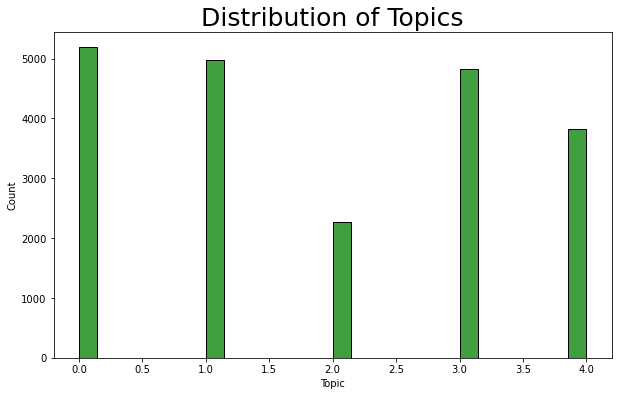

In [56]:
# Plotting a histogram of topics
plt.figure(figsize=[10,6])
sns.histplot(data=training_data, x='Topic',color='Green', )
plt.title("Distribution of Topics", fontsize=25)
plt.show()

#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [57]:

#Write your code to get the Vector count
count_vector=CountVectorizer()

#Write your code here to transform the word vector to tf-idf
X_train_count=count_vector.fit_transform(training_data['complaint_what_happened'])

# Transform the word vector to tf-idf
tfidf_transform= TfidfTransformer()
X_train_tfidf = tfidf_transform.fit_transform(X_train_count)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [58]:
# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (15804, 27984)
y_train Shape: (15804,)
X_test Shape: (5268, 27984)
y_test Shape: (5268,)


In [59]:
# Create a function to evaluate models
def model_eval(y_test, y_pred, model_name):
    
    # print classification report of classifier
    print(f"CLASSIFICATION REPORT for {model_name}\n")
    print(classification_report(y_test, y_pred, target_names=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"]))
    
    # plot confusion matrix of the classifier
    plt.figure(figsize=(10,7))
    plt.title(f"CONFUSION MATRIX for {model_name}\n")
    matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(matrix, annot=True, cbar=None, cmap="Greens", fmt='d', xticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"], yticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"])
    plt.show()
    
    return

# Model:1  - `Logistic Regression`

In [60]:
# Import required library
from sklearn.linear_model import LogisticRegression

In [61]:
# Run the Logistic Regression model with default parameters
model_name = 'LOGISTIC REGRESSION'
lr = LogisticRegression() 
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [62]:
# Hyperparameter tuning for best result
param_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001,0.01,0.1,1,10,100],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

grid_lr = GridSearchCV(estimator=lr, 
                       param_grid=param_lr,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_lr.fit(X_train, y_train)
print(grid_lr.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
{'C': 1, 'penalty': 'l1', 'solver': 'saga'}


In [63]:
# Creating model with best hyperparameter
lr_tuned = LogisticRegression(C=1, 
                                  penalty='l1', 
                                  solver='saga')

lr_tuned.fit(X_train, y_train)
y_pred_lr_tuned = lr_tuned.predict(X_test)

In [64]:
# Calculate F1 Score of tuned model using weighted average method
f1_lr = f1_score(y_test, y_pred_lr_tuned, average="weighted")
f1_lr

0.9445174403518327

CLASSIFICATION REPORT for LOGISTIC REGRESSION

                             precision    recall  f1-score   support

      Bank Account services       0.95      0.96      0.96      1306
Credit card or prepaid card       0.95      0.95      0.95      1276
                     Others       0.94      0.95      0.94       561
    Theft/Dispute Reporting       0.93      0.92      0.93      1207
              Mortgage/Loan       0.95      0.94      0.94       918

                   accuracy                           0.94      5268
                  macro avg       0.94      0.94      0.94      5268
               weighted avg       0.94      0.94      0.94      5268



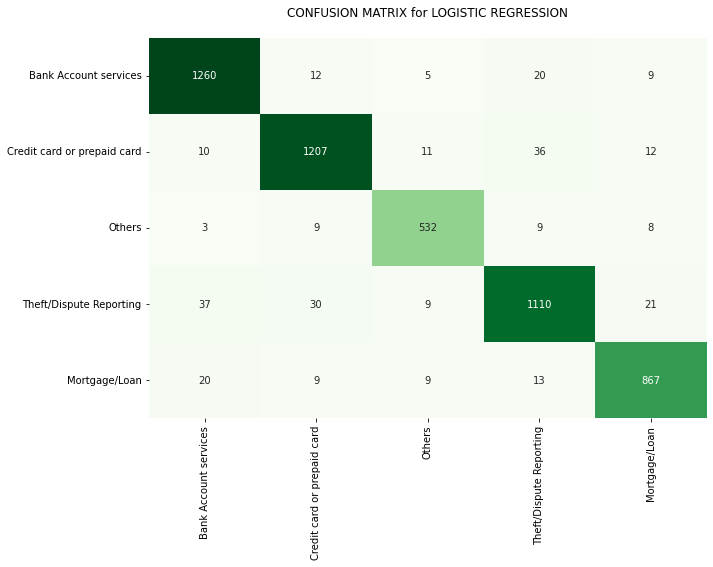

In [65]:
# Evaluate the tuned Logistic Regression classifier
model_eval(y_test, y_pred_lr_tuned, model_name)

In [66]:
# Create a dataframe to store F1 Scores of all models we will build
f1_summary = pd.DataFrame([{'Model': 'Logistic Regression','F1 Score': round(f1_lr, 2)}])
f1_summary

,Model,F1 Score
0,Logistic Regression,0.94


# Model:2  - `Decision Tree`

In [67]:
# Import required library
from sklearn.tree import DecisionTreeClassifier

In [68]:
# Run Decision Tree with default hyperparameters
model_name = 'DECISION TREE'
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt =dt.predict(X_test)

In [69]:
# Hyperparameter tuning for best result
param_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [5, 10, 15, 20, 25, 30],
    'min_samples_leaf':[1,5,10,15, 20, 25],
    
}

grid_dt = GridSearchCV(estimator=dt, 
                       param_grid=param_dt,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_dt.fit(X_train, y_train)
print(grid_dt.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 15}


In [70]:
# Creating model with best hyperparameter
dt_tuned = DecisionTreeClassifier(criterion='gini', 
                                      max_depth=25, 
                                      min_samples_leaf=15, 
                                      )
dt_tuned.fit(X_train, y_train)
y_pred_dt_tuned = dt_tuned.predict(X_test)

In [71]:
# Calculate F1 Score of tuned model using weighted average method
f1_dt = f1_score(y_test, y_pred_dt_tuned, average="weighted")
f1_dt

0.7991068076438096

CLASSIFICATION REPORT for DECISION TREE

                             precision    recall  f1-score   support

      Bank Account services       0.79      0.83      0.81      1306
Credit card or prepaid card       0.84      0.82      0.83      1276
                     Others       0.77      0.76      0.77       561
    Theft/Dispute Reporting       0.76      0.73      0.75      1207
              Mortgage/Loan       0.81      0.84      0.82       918

                   accuracy                           0.80      5268
                  macro avg       0.80      0.80      0.80      5268
               weighted avg       0.80      0.80      0.80      5268



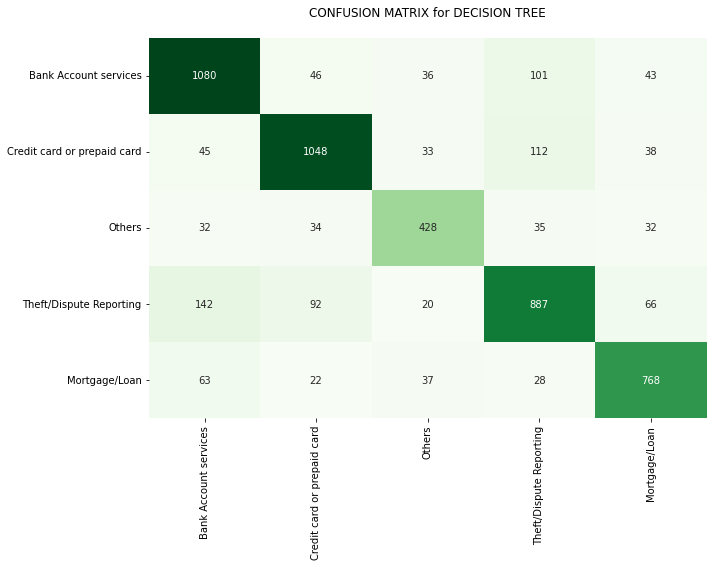

In [72]:
# Evaluate the tuned Decision Tree classifier
model_eval(y_test, y_pred_dt_tuned, model_name)

In [73]:
# Update the summary table
f1_summary.loc[len(f1_summary.index)] = ['Decision Tree', round(f1_dt, 2)]
f1_summary

,Model,F1 Score
0,Logistic Regression,0.94
1,Decision Tree,0.80


# Model:3  - `Random Forest`

In [74]:
from sklearn.ensemble import RandomForestClassifier
parameters = {'max_depth': [5, 10, 20],
              'max_features': [2,5,10],
              'min_samples_leaf':[5,10,20,30,50],
              'n_estimators':[10,30,50,100,200]}
rf0 = RandomForestClassifier(random_state=42)

In [75]:
rf_cv = RandomizedSearchCV(estimator=rf0,
                           param_distributions=parameters,
                     cv=5,
                     n_jobs=-1,
                     verbose=1,
                     scoring="f1_weighted")

In [76]:
%%time
rf_cv.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Wall time: 3.58 s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 20],
                                        'max_features': [2, 5, 10],
                                        'min_samples_leaf': [5, 10, 20, 30, 50],
                                        'n_estimators': [10, 30, 50, 100, 200]},
                   scoring='f1_weighted', verbose=1)

In [77]:
rf_best = rf_cv.best_estimator_
rf_best

RandomForestClassifier(max_depth=20, max_features=10, min_samples_leaf=10,
                       n_estimators=30, random_state=42)

In [78]:
rf_best.fit(X_train,y_train)

y_train_pred_rf = rf_best.predict(X_train)
y_test_pred_rf = rf_best.predict(X_test)

In [79]:
# Calculate F1 Score of tuned model using weighted average method
f1_rf = f1_score(y_test, y_test_pred_rf, average="weighted")
f1_rf

0.34284940025053134

CLASSIFICATION REPORT for DECISION TREE

                             precision    recall  f1-score   support

      Bank Account services       0.32      0.90      0.47      1306
Credit card or prepaid card       0.54      0.41      0.46      1276
                     Others       0.00      0.00      0.00       561
    Theft/Dispute Reporting       0.65      0.31      0.42      1207
              Mortgage/Loan       0.98      0.05      0.10       918

                   accuracy                           0.40      5268
                  macro avg       0.50      0.33      0.29      5268
               weighted avg       0.53      0.40      0.34      5268



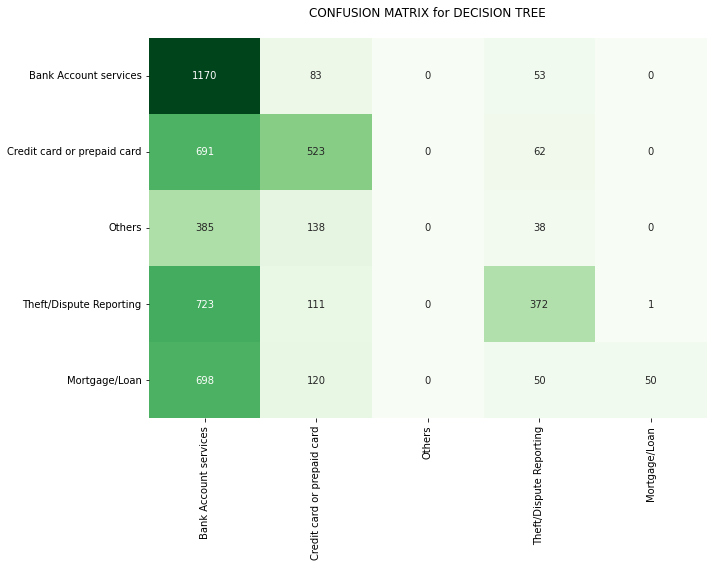

In [80]:
# Evaluate the tuned Decision Tree classifier
model_eval(y_test, y_test_pred_rf, model_name)

In [81]:
# Update the summary table
f1_summary.loc[len(f1_summary.index)] = ['Random Forest', round(f1_rf, 2)]
f1_summary

,Model,F1 Score
0,Logistic Regression,0.94
1,Decision Tree,0.80
2,Random Forest,0.34


# Model 4:  - `Naive Bayes`

In [82]:
# Import required library
from sklearn.naive_bayes import MultinomialNB

In [83]:
# Run the Multinomial Naive Bayes with default parameters
model_name = 'NAIVE BAYES'
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

In [84]:
# Hyperparameter tuning for best result
param_nb = {
    'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),
    'fit_prior':[True, False]
}

grid_nb = GridSearchCV(estimator=nb, 
                       param_grid=param_nb,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=10)
grid_nb.fit(X_train, y_train)
print(grid_nb.best_params_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
{'alpha': 0.1, 'fit_prior': False}


In [85]:
# Creating model with best hyperparameter
model_name = 'NAIVE BAYES'
nb_tuned = MultinomialNB(alpha=0.1,fit_prior=False)
nb_tuned.fit(X_train, y_train)
y_pred_nb_tuned = nb_tuned.predict(X_test)

In [86]:
# Calculate F1 Score of model using weighted average method
f1_nb = f1_score(y_test, y_pred_nb_tuned, average="weighted")
f1_nb

0.7805581038304822

CLASSIFICATION REPORT for NAIVE BAYES

                             precision    recall  f1-score   support

      Bank Account services       0.78      0.83      0.81      1306
Credit card or prepaid card       0.80      0.75      0.78      1276
                     Others       0.66      0.64      0.65       561
    Theft/Dispute Reporting       0.77      0.77      0.77      1207
              Mortgage/Loan       0.84      0.84      0.84       918

                   accuracy                           0.78      5268
                  macro avg       0.77      0.77      0.77      5268
               weighted avg       0.78      0.78      0.78      5268



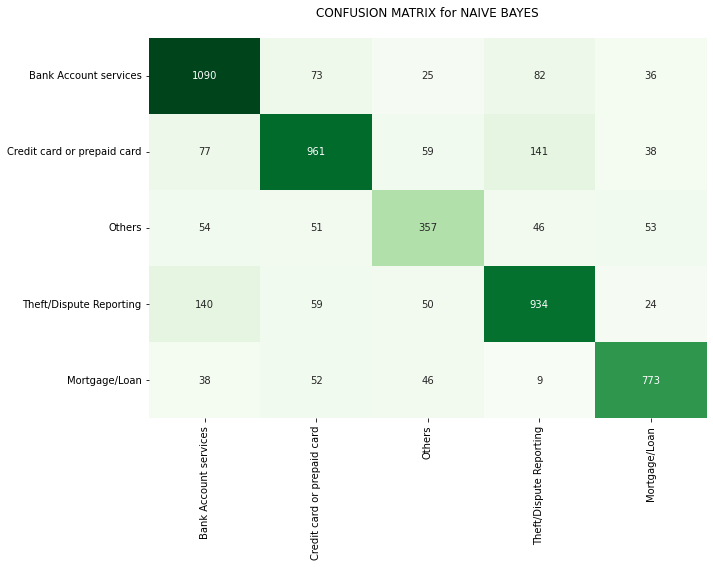

In [87]:
# Evaluate the Naive Bayes classifier
model_eval(y_test, y_pred_nb_tuned, model_name)

In [88]:
# Update the summary table
f1_summary.loc[len(f1_summary.index)] = ['Naive Bayes', round(f1_nb, 2)]
f1_summary

,Model,F1 Score
0,Logistic Regression,0.94
1,Decision Tree,0.80
2,Random Forest,0.34
3,Naive Bayes,0.78


## As per the F1 score of all the 4 models, Logistic Regression performs best with F1 score : 0.94

# Predicting topics via Logistic Regression on custom text

In [89]:
# Function to predict a topic for custom text

def topic_predicter(text):
    
    target_names = ["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting", "Mortgage/Loan"]

    X_new_count = count_vector.transform(text)
    X_new_tfidf = tfidf_transform.transform(X_new_count)
    prediction = lr_tuned.predict(X_new_tfidf)

    return target_names[prediction[0]]

In [90]:
# Create a dataframe of some sample customer complaints
df_custom = pd.DataFrame({'complaints': ["This is the notification addressing the dispute against +\
the amount that was mistakenly charged to my credit card. My credit card  +\
number, XCXCXXC, keeps a running log of all payments made on time for all  +\
invoices. I want to let you know that the bank statement they sent me,  +\
dated February 20, 2014, has an incorrect charge for Rs. 10,000. An image  +\
of the statement with the false accusation circled in red is included in this  +\
message. Since I returned the item shortly after, this particular payment was  +\
canceled the same day. It was billed under the name of -Creditor. I've sent a  +\
copy of the cancelled bill and the creditor's signed authorization. To my  +\
great surprise, this amount was included in my bills because never before  +\
has such an error happened in the billings of my credit card.", 
                                  "This letter is intended to ask for a small +\
business loan in the amount of $20,000 so that we can expand our warehouse. +\
On June 1, 2020, Entirely Electronics opened its doors with just two staff members. +\
Entirely Electronics +\
has expanded steadily as a partnership and now employs 20 +\
people full-time. Getting a fair piece of the online +\
electronic retail market has been fairly profitable for Entirely +\
Electronics. Our  +\
presence online has expanded beyond just our website to include Facebook,  +\
Instagram, and Yelp. Entirely Electronics regularly attracts new customers  +\
because to our marketing strategies, and we take pride in our high customer  +\
retention rate.",
                                  "I want to change my savings account to a  +\
current account with a zero balance option. Please  +\
advise me on how to go about doing that."]})
df_custom

,complaints
0,"This is the notification addressing the dispute against +the amount that was mistakenly charged to my credit card. My credit card +number, XCXCXXC, keeps a running log of all payments made on time for all +invoices. I want to let you know that the bank statement they sent me, +dated February 20, 2014, has an incorrect charge for Rs. 10,000. An image +of the statement with the false accusation circled in red is included in this +message. Since I returned the item shortly after, this particular payment was +canceled the same day. It was billed under the name of -Creditor. I've sent a +copy of the cancelled bill and the creditor's signed authorization. To my +great surprise, this amount was included in my bills because never before +has such an error happened in the billings of my credit card."
1,"This letter is intended to ask for a small +business loan in the amount of $20,000 so that we can expand our warehouse. +On June 1, 2020, Entirely Electronics opened its doors with just two staff members. +Entirely Electronics +has expanded steadily as a partnership and now employs 20 +people full-time. Getting a fair piece of the online +electronic retail market has been fairly profitable for Entirely +Electronics. Our +presence online has expanded beyond just our website to include Facebook, +Instagram, and Yelp. Entirely Electronics regularly attracts new customers +because to our marketing strategies, and we take pride in our high customer +retention rate."
2,I want to change my savings account to a +current account with a zero balance option. Please +advise me on how to go about doing that.


In [91]:
# Create a new column of predicted topics of each complaint, predicted using the tuned Logistic Regression model
df_custom['predicted topic'] = df_custom['complaints'].apply(lambda x: topic_predicter([x]))
df_custom

,complaints,predicted topic
0,"This is the notification addressing the dispute against +the amount that was mistakenly charged to my credit card. My credit card +number, XCXCXXC, keeps a running log of all payments made on time for all +invoices. I want to let you know that the bank statement they sent me, +dated February 20, 2014, has an incorrect charge for Rs. 10,000. An image +of the statement with the false accusation circled in red is included in this +message. Since I returned the item shortly after, this particular payment was +canceled the same day. It was billed under the name of -Creditor. I've sent a +copy of the cancelled bill and the creditor's signed authorization. To my +great surprise, this amount was included in my bills because never before +has such an error happened in the billings of my credit card.",Theft/Dispute Reporting
1,"This letter is intended to ask for a small +business loan in the amount of $20,000 so that we can expand our warehouse. +On June 1, 2020, Entirely Electronics opened its doors with just two staff members. +Entirely Electronics +has expanded steadily as a partnership and now employs 20 +people full-time. Getting a fair piece of the online +electronic retail market has been fairly profitable for Entirely +Electronics. Our +presence online has expanded beyond just our website to include Facebook, +Instagram, and Yelp. Entirely Electronics regularly attracts new customers +because to our marketing strategies, and we take pride in our high customer +retention rate.",Mortgage/Loan
2,I want to change my savings account to a +current account with a zero balance option. Please +advise me on how to go about doing that.,Bank Account services


# We conclude that the Logistic Regression model is predicting well on custom data